In [1]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import nltk
from nltk.stem import *
from nltk.corpus import stopwords
import math
# download required resources
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicolwon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicolwon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
DATA_DIR = "20_newsgroups"

## Functions from lab

In [3]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [4]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [6]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [7]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [ ]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [8]:
def get_all_files():
    return [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [10]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [12]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9124812459812817
Test accuracy: 0.6978333333333333


### Q1 (a)

[Write your answer here]

Feature set - a set of 1000 of the most frequent words from the newsgroup documents. A good portion of these are stop words (ie. the, and, to) or are related to the header (and not relevant to the actual text) (ie. From, Subject, ID).


Amount of data - there are 19997 documents, and a total of 232013 unique words. The binary_baseline_data function only uses the most common 1000 words.


Hyperparameters - these include the train and test size (which here is 70% and 30% of the dataset respectively), and the number of features (number of most common words). There are also hyperparameters within the logistic regression classifier itself - for instance C (inverse of regularization strength, in which regularization adds a penalty to the loss function to prevent overfitting), the type of regularization (L1 vs L2), solver type (ie. newton-cg, liblinear etc.).

### Q1 (b)

Modify the following function:

Note: I referenced https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

In [13]:
def clean_file_text_v2(text):
    new_text = re.sub("Path:.*?\n", "", text)
    new_text = re.sub("From:.*?\n", "", text)
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Organization:.*?\n", "", text)
    new_text = re.sub("Lines:.*?\n", "", text)
    new_text = re.sub("Message-ID:.*?\n", "", text)
    new_text = re.sub("References:.*?\n", "", text)
    new_text = re.sub("Reply-To:.*?\n", "", text)
    new_text = re.sub("NNTP-Posting-Host:.*?\n", "", text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [14]:
def corpus_count_words_v2(file_list):
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text_v2(file_data)
            file_words = tokenizer.tokenize(file_data)
            new_file_words = [word for word in file_words if word not in stop_words]
            word_counter.update(new_file_words)
    return word_counter

In [15]:
def binary_improved_data(file_list, num_words = 1000):
    # Put your code here
    ###
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words_v2(file_list)
    
    # Select the most common numWords​def binary_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    stop_words = set(stopwords.words('english'))
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text_v2(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [word for word in file_words if word not in stop_words]
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    
    X = pd.DataFrame(df_rows, columns = word_list)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [26]:
# get the baseline data
X, y = binary_improved_data(all_files)

# Write your code here:
# You need to split the data and train a logistic regression classifier.
# Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)


# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9796384939629921
Test accuracy: 0.9513333333333334


[Write your answer here]

Both test and train accuracy increased, with test accuracy increasing significantly from 70% to 95%.

### Q1 (d)

Modify the partial code below

In [16]:
def multiple_train_test_results(X, y, num_tests):
    train_results = []
    test_results = []
    
    for i in range(num_tests):
        state = random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        train_results.append(train_accuracy)
        test_results.append(test_accuracy)
    
    return train_results, test_results

In [17]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    
    train_results, test_results = multiple_train_test_results(X, y, num_tests)
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [29]:
X, y = binary_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9813745802672
Train confidence interval over 10 random splits: [0.9809415518203358, 0.9818076087140643]
Test mean accuracy over 10 random splits: 0.9486333333333332
Test confidence interval over 10 random splits: [0.9474749360752267, 0.9497917305914397]


[ Write your answer here ]

The average and 95% confidence intervals tell me that the accuracy is consistent at the average over different splits. This is useful (and more useful than a single trial) because it proves that the model is not overfitting to one set of data.

### Q1 (f)

Modify the partial code below

In [18]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # Write your code here
    for i in range(num_tests):
        state = random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        
        cm = confusion_matrix(y_test, y_test_predict)
        cm_list.append(cm)
        
    
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = pd.Panel(cm_list).sum(axis=0)
    
    # validate return type
    assert isinstance(combined_cm, pd.DataFrame), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

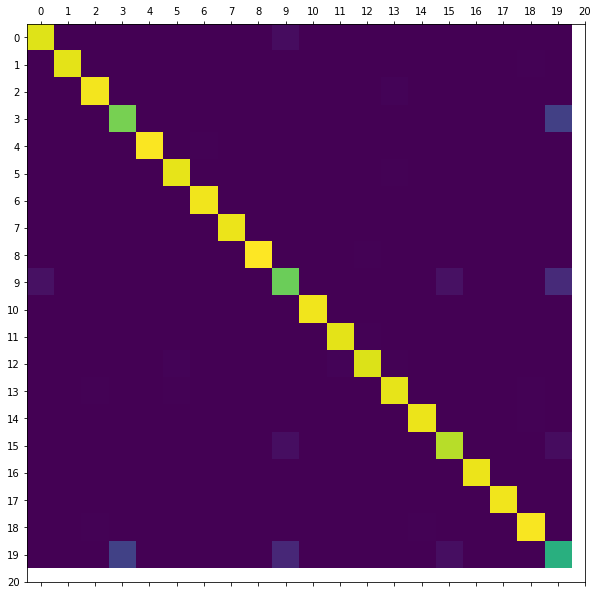

In [28]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

In [ ]:
cm10

[ Write your answer here ]

Classes 0, 3, 9 and 19 are more easily confused. This is because classes 9 and 19 are both miscellaneous and aren't attributable to a single topic, making them harder to classify. Classes 0 and 3 when confused, are confused with classes 9 and 19.

## Q2

### Q2 (a)

Modify the partial code below

In [21]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        # ......

        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)
        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

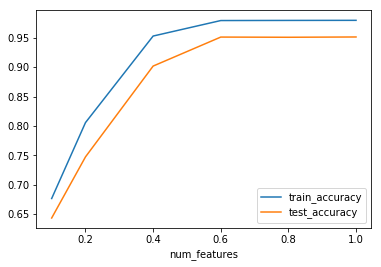

In [30]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

[ Write your answer here ]

The model's accuracy increases significantly as the number of features increases, but at 0.6 (600 features) the accuracy stops improving.

## Q3

### Q3 (a)

Modify the partial code below

In [19]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        # ......
        clf = LogisticRegression(C=param).fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

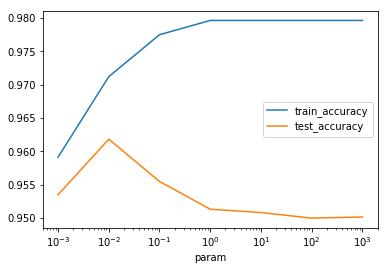

In [31]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

[ Write your answer here ]

As C increases, the test accuracy increases and then worsens after C reaches 10^-2. (High C leads to more overfitting (C increases --> lambda decreases --> more overfitting))

## Q4

### Q4 (a)

Modify the partial code below

In [20]:
def compute_tf(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    tfDict = []
    news_cnt = corpus_count_words_v2(file_list)
    word_list = [word for (word, freq) in news_cnt.most_common(1000)]
    
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text_v2(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [word for word in file_words if word not in stop_words]
            count = dict(Counter(file_words))
            tfDict.append([count[word] if word in count else 0 for word in word_list])
    X = pd.DataFrame(tfDict, columns = word_list)
    
    return X

In [22]:
def compute_idf(file_list):
    X, y = binary_improved_data(file_list)
    return pd.DataFrame([pd.Series(X.sum())])

In [23]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words_v2(file_list)
    
    # Select the most common numWords​def binary_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below

    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    stop_words = set(stopwords.words('english'))
                     
    tf = compute_tf(file_list)
    idf = compute_idf(file_list)
    N = len(file_list)
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for filenum, file_path in enumerate(file_list):
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text_v2(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [word for word in file_words if word not in stop_words]
            df_rows.append([math.log10(1+tf[word][filenum])*math.log10(N/idf[word]) if word in file_words else 0 for word in word_list])      
    
    X = pd.DataFrame(df_rows, columns = word_list)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [27]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.978652568407516
Train confidence interval over 10 random splits: [0.9780640013348604, 0.9792411354801717]
Test mean accuracy over 10 random splits: 0.9492333333333333
Test confidence interval over 10 random splits: [0.9478415669577199, 0.9506250997089466]


[ Write your answer here ]

The train mean accuracy and confidence intervals of tf-idf is still lower than that of binary encoding by 0.3%, however the test mean accuracy and confidence intervals is higher than that of binary encoding by about 0.2%. Overall the results are very close, as the mean accuracy and confidence intervals of both binary encoding and tf-idf encoding are quite high. However, tf-idf is marginally better, likely because you can train your classifier to put emphasis on words that are more 'important', rather than equally weight all words.

## Q5

### Q5 (a)

Modify the partial code below

In [24]:
def multiple_train_test_results_nb(X, y, num_tests):
    train_results = []
    test_results = []
    
    for i in range(num_tests):
        state = random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)
        clf = BernoulliNB().fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        train_results.append(train_accuracy)
        test_results.append(test_accuracy)
    
    return train_results, test_results

In [25]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    train_results, test_results = multiple_train_test_results(X_tf, y_tf, num_tests)
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [32]:
X, y = binary_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9785739801386011
Train confidence interval over 10 random splits: [0.9779188373555338, 0.9792291229216684]
Test mean accuracy over 10 random splits: 0.9490666666666666
Test confidence interval over 10 random splits: [0.9471880821853905, 0.9509452511479427]


[ Write your answer here ]

Using the Bernoulli Naive Bayes classifier, we achieve similar results to that of Logistic Regression classifier. I think this is because although logistic regression can be a better classifier, there is a large amount of a data, and this allows both classifiers to perform well. Additionally, the classifier just needs to predict classes, not accurately predict probabilities, which is where logistic regression classifiers perform significantly better.

## Q6

In [ ]:
def is_graduate_student():
    # ** Graduate students: change the return value to True **
    return False

### Q6 (a)

Modify the partial code below

In [ ]:
def binary_med_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    X = None
    y = None
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [ ]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

[ Write your answer here ]